# Project Setup

In [1]:
# all import statements needed for the project
import requests 
import bs4
import pandas as pd
import re
from math import sin, cos, sqrt, atan2, radians
from io import StringIO
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.orm import declarative_base
from sqlalchemy import Column, Integer, String
from sqlalchemy.orm import validates
import sqlite3
from keplergl import KeplerGl
import seaborn as sns
%matplotlib inline

# Part 1: Data Preprocessing

## Uber Dataset

In [3]:
df_uber=pd.read_csv("uber_rides_sample.csv")

In [4]:
def distance(row):
    R = 6373.0
    
    lon1 = radians(row["pickup_longitude"])
    lat1 = radians(row["pickup_latitude"])
    
    lon2 = radians(row["dropoff_longitude"])
    lat2 = radians(row["dropoff_latitude"])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [6]:
def uber_data_cleaning(df_uber):
    df_uber.dropna()
    df_uber.drop("Unnamed: 0" , axis=1, inplace=True)
    
    pick_long_check=(df_uber["pickup_longitude"]>= -74.242330) & (df_uber["pickup_longitude"]<= -73.717047)
    drop_long_check=(df_uber["dropoff_longitude"]>= -74.242330) & (df_uber["dropoff_longitude"]<= -73.717047)
    pick_latt_check=(df_uber["pickup_latitude"]>= 40.560445) & (df_uber["pickup_latitude"]<= 40.908524)
    drop_latt_check=(df_uber["dropoff_latitude"]>= 40.560445) & (df_uber["dropoff_latitude"]<= 40.908524)

    df_uber=df_uber[pick_long_check & drop_long_check & pick_latt_check & drop_latt_check]
    
    df_uber['pickup_datetime'] = pd.to_datetime(df_uber['pickup_datetime'])
    df_uber['pickup_datetime']=df_uber['pickup_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    df_uber['distance'] = df_uber.apply(distance, axis=1)
    
    return df_uber

In [7]:
df_uber=uber_data_cleaning(df_uber)

<ipython-input-6-de374cc63ef3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uber['pickup_datetime'] = pd.to_datetime(df_uber['pickup_datetime'])
<ipython-input-6-de374cc63ef3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uber['pickup_datetime']=df_uber['pickup_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-6-de374cc63ef3>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

## Yellow Taxi Dataset

In [ ]:
def link_parser(): 
    # Scrapping out link for each of yellow trip data
    
    response = requests.get('https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page')
    soup = bs4.BeautifulSoup(response.content, 'html.parser')
    parse = str(soup.find_all("li")).split()
    pattern = re.compile(r"href=\"https:\/\/s3\.amazonaws\.com\/nyc\-tlc\/trip\+data\/yellow\_tripdata\_20[0-1]\d")
    newlist = list(filter(pattern.match, parse))
    newlist = newlist[42:]
    linklist=[]
    for item in newlist:
        linklist.append(item.split('href="')[1][:-1])
    return linklist


In [ ]:
def yellow_taxi_dataset(linklist):
    result=pd.DataFrame()
    #Data collection of 2015's yellow taxi data
    for link in linklist[:12]:
        req = requests.get(link)
        url_content = req.content
    
        s=str(url_content,'utf-8')
        data = StringIO(s) 
        df=pd.read_csv(data, error_bad_lines=False)
        df.drop("improvement_surcharge" , axis=1, inplace=True)
        df = df.iloc[: , :-1]
        df.columns=['vendor_id','pickup_datetime','dropoff_datetime','passenger_count','trip_distance','pickup_longitude',
                'pickup_latitude','rate_code','store_and_fwd_flag','dropoff_longitude','dropoff_latitude','payment_type',
                'fare_amount','surcharge','mta_tax','tip_amount','tolls_amount','total_amount']
        df = df.sample(n=3000)
    
        result=result.append(df)
    #Data collection of years from 2009 to 2014    
    for link in linklist[12:]:
        req = requests.get(link)
        url_content = req.content
    
        s=str(url_content,'utf-8')
        data = StringIO(s) 
        df=pd.read_csv(data, error_bad_lines=False)
        df.columns=['vendor_id','pickup_datetime','dropoff_datetime','passenger_count','trip_distance','pickup_longitude',
                'pickup_latitude','rate_code','store_and_fwd_flag','dropoff_longitude','dropoff_latitude','payment_type',
                'fare_amount','surcharge','mta_tax','tip_amount','tolls_amount','total_amount']
        df = df.sample(n=3000)
    
        result=result.append(df)
        
    return result
    

In [9]:
def clean_yellowtaxi(df_taxi):
    
    #location filter
    pick_long_check=(df_taxi["pickup_longitude"]>= -74.242330) & (df_taxi["pickup_longitude"]<= -73.717047)
    drop_long_check=(df_taxi["dropoff_longitude"]>= -74.242330) & (df_taxi["dropoff_longitude"]<= -73.717047)
    pick_latt_check=(df_taxi["pickup_latitude"]>= 40.560445) & (df_taxi["pickup_latitude"]<= 40.908524)
    drop_latt_check=(df_taxi["dropoff_latitude"]>= 40.560445) & (df_taxi["dropoff_latitude"]<= 40.908524)

    df_taxi=df_taxi[pick_long_check & drop_long_check & pick_latt_check & drop_latt_check]
    
    #drop columns with too many NAs
    na_bar = len(df_taxi) * .8
    df_taxi = df_taxi.dropna(thresh=na_bar, axis=1)
    
    #add distance column
    df_taxi['distance'] = df_taxi.apply(distance, axis=1)
    
    #drop trip_distance col
    df_taxi = df_taxi.drop(['trip_distance'], axis = 1)

    
    return df_taxi

In [ ]:
# Calling Functions to parse the links of the csv files and download the dataset
linklist=link_parser()
df_taxi=yellow_taxi_dataset(linklist)

In [10]:
#For Project Convience, we convert the result from the downloading steps to a csv.
df_taxi=pd.read_csv("Yellow_Taxi_Sample.csv")
df_taxi=clean_yellowtaxi(df_taxi)

In [11]:
#Test Case for Distance Function
def distance_test():
    
    distance_test=round(distance(df_taxi.iloc[[0]]),2)   
    assert distance_test== 0.88

In [12]:
distance_test()

## Weather Dataset

In [ ]:
def concact_weather_data():
    # setting the path for joining multiple files
    files = os.path.join("/Users/nat/Desktop/tfa/proj", "*weather.csv") #directory change needed

    # list of merged files returned
    files = glob.glob(files)

    # joining files with concat and store csv
    df_weather = pd.concat(map(pd.read_csv, files), ignore_index=True)
    #df_weather.to_csv('weather_all.csv',index=False)  
    
    return df_weather

In [13]:
def clean_weather(df_weather):
    #choose only useful cols
    df_weather_cleaned = df_weather[df_weather.filter(regex='DATE|speed|Speed|Precipitation|precipitation').columns[:8]]
    
    #Separating the weather datasets into hourly data and daily data
    df_weather_hourly = df_weather_cleaned[df_weather_cleaned.filter(regex='DATE|hourly|Hourly').columns[:]]
    df_weather_daily = df_weather_cleaned[df_weather_cleaned.filter(regex='DATE|daily|Daily').columns[:]]
    
    return df_weather_hourly,df_weather_daily

In [14]:
#df_weather=concact_weather_data()
#For Project Convience, a pre-stored csv is used
df_weather=pd.read_csv("weather_all.csv")
df_weather_hourly,df_weather_daily=clean_weather(df_weather)

/Users/lisakuai/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7,8,9,10,13,17,18,19,40,41,42,61,65,78,88,89,90,91,92,93,94,95,96,97,98,99) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Part 2: Storing Data

Using SqlAlchemy packages to create 4 different tables that have been cleaned from pervious steps.

In [51]:
def database():
    
    engine = create_engine(f"sqlite:///final_project.db")
    Base = declarative_base()
    
    # Convert csv file into sql & insert into data.db
    df_uber.to_sql('Uber_trips', con=engine, index=True, index_label='id', if_exists='replace')
    df_taxi.to_sql('Yellow_Taxi_trips', con=engine, index=True, index_label='id', if_exists='replace')
    df_weather_daily.to_sql('Daily_Weather_Information', con=engine, index=True, index_label='id', if_exists='replace')
    df_weather_hourly.to_sql('Hourly_Weather_Information', con=engine, index=True, index_label='id', if_exists='replace')

In [52]:
database()

In [15]:
# Creating schema.sql file
with open("schema.sql", "a") as f:
        f.write(pd.io.sql.get_schema(df_uber, 'Uber_trips'))
        f.write(';\n\n')
        f.write(pd.io.sql.get_schema(df_taxi, 'Yellow_Taxi_trips'))
        f.write(';\n\n')
        f.write(pd.io.sql.get_schema(df_weather_daily, 'Daily_Weather_Information'))
        f.write(';\n\n')
        f.write(pd.io.sql.get_schema(df_weather_hourly, 'Hourly_Weather_Information'))
        f.write(';')

# Part 3: Understanding Data

Writing Sql Query to answer the listed questions within the section

In [17]:
connection = sqlite3.connect("final_project.db")

1.	For 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.

In [18]:
with connection:
    Q1 = connection.execute(
        """SELECT strftime('%H', y.pickup_datetime) as Hour, count(*) as Counts
                                From Yellow_Taxi_trips y
                                where date(y.pickup_datetime)>="2009-01-01" and date(y.pickup_datetime)<="2015-06-30"
                                group by Hour
                                order by Counts desc""")

In [57]:
for row in Q1:
    print(row)

('19', 14246)
('18', 13868)
('20', 13576)
('21', 13047)
('22', 12742)
('14', 11446)
('17', 11335)
('23', 11295)
('12', 11085)
('15', 11070)
('13', 11057)
('09', 10625)
('08', 10471)
('11', 10438)
('10', 10356)
('16', 9615)
('00', 9141)
('07', 8282)
('01', 6766)
('02', 5013)
('06', 4703)
('03', 3685)
('04', 2713)
('05', 2224)


In [20]:
#Creating sql file
Q1="""SELECT strftime('%H', y.pickup_datetime) as Hour, count(*) as Counts
                                From Yellow_Taxi_trips y
                                where date(y.pickup_datetime)>="2009-01-01" and date(y.pickup_datetime)<="2015-06-30"
                                group by Hour
                                order by Counts desc"""
with open("Yello_Taxi_Popular_Hours.sql", "w+") as f:
        f.write(Q1)

2.	For the same time frame, what day of the week was the most popular to take an Uber? The result should have 7 bins.

In [58]:
with connection:
    Q2 = connection.execute(
        """SELECT strftime('%w', u.pickup_datetime) as weekofday, count(*) as Counts
                                From Uber_trips u
                                where date(u.pickup_datetime)>="2009-01-01" and date(u.pickup_datetime)<="2015-06-30"
                                group by weekofday
                                order by Counts desc""")

In [59]:
for item in Q2:
    print(item)

('5', 30166)
('6', 29599)
('4', 29338)
('3', 28328)
('2', 27526)
('0', 25834)
('1', 24681)


In [21]:
#Creating sql file
Q2= """SELECT strftime('%w', u.pickup_datetime) as weekofday, count(*) as Counts
                                From Uber_trips u
                                where date(u.pickup_datetime)>="2009-01-01" and date(u.pickup_datetime)<="2015-06-30"
                                group by weekofday
                                order by Counts desc"""

with open("Uber_Popular_Day_Of_Week.sql", "w+") as f:
        f.write(Q2)

3.	What is the 95% percentile of distance traveled for all hired trips during July 2013?

In [60]:
with connection:
    Q3 = connection.execute(
        """ with newtable as 
                (SELECT distance from Uber_trips
                 Where date(pickup_datetime)<="2013-07-31" and date(pickup_datetime)>="2013-07-1"
            
                 Union all
            
                SELECT distance from Yellow_Taxi_trips
                Where date(pickup_datetime)<="2013-07-31" and date(pickup_datetime)>="2013-07-1")
            
            Select distance as "95% distance"
            FROM newtable
            ORDER BY distance ASC
            LIMIT 1
            OFFSET (SELECT
             COUNT(*)
            FROM newtable
            ) * 95 / 100 - 1
            
            """)

In [61]:
for item in Q3:
    print(item)

(10.430214496267116,)


In [22]:
#Creating sql file
Q3= """ with newtable as 
                (SELECT distance from Uber_trips
                 Where date(pickup_datetime)<="2013-07-31" and date(pickup_datetime)>="2013-07-1"
            
                 Union all
            
                SELECT distance from Yellow_Taxi_trips
                Where date(pickup_datetime)<="2013-07-31" and date(pickup_datetime)>="2013-07-1")
            
            Select distance as "95% distance"
            FROM newtable
            ORDER BY distance ASC
            LIMIT 1
            OFFSET (SELECT
             COUNT(*)
            FROM newtable
            ) * 95 / 100 - 1
            
            """

with open("July2013_95%_Distance.sql", "w+") as f:
        f.write(Q3)

4.	What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

In [62]:
with connection:
    Q4 = connection.execute(
        """ with newtable as 
                (SELECT distance, date(pickup_datetime) as date from Uber_trips
                 Where strftime('%Y', pickup_datetime)="2009"
            
                 Union all
            
                SELECT distance, date(pickup_datetime) as date from Yellow_Taxi_trips
                Where strftime('%Y', pickup_datetime)="2009")
            
            Select date, Avg(distance) as Avg_dist 
            FROM newtable
            Group by date
            Order by Count(*) desc
            LIMIT 10
            
            """)

In [63]:
for item in Q4:
    print(item)

('2009-10-23', 2.8750806400754474)
('2009-07-23', 3.141376992097748)
('2009-08-14', 3.1066621910406735)
('2009-12-11', 2.915932452752843)
('2009-06-05', 3.032279559824318)
('2009-02-20', 2.7511630452917912)
('2009-03-06', 2.9318889606681013)
('2009-01-31', 3.1153235637726295)
('2009-12-18', 2.8862065653873272)
('2009-04-18', 3.543311738881416)


In [23]:
#Creating sql file
Q4= """ with newtable as 
                (SELECT distance, date(pickup_datetime) as date from Uber_trips
                 Where strftime('%Y', pickup_datetime)="2009"
            
                 Union all
            
                SELECT distance, date(pickup_datetime) as date from Yellow_Taxi_trips
                Where strftime('%Y', pickup_datetime)="2009")
            
            Select date, Avg(distance) as Avg_dist 
            FROM newtable
            Group by date
            Order by Count(*) desc
            LIMIT 10
            
            """

with open("2019_Top10_Days_Number_of_Rides.sql", "w+") as f:
        f.write(Q4)

5.	Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?

In [64]:
with connection:
    Q5 = connection.execute(
        """ with newtable as 
            (Select date, sum(num_trip) as num_trips
                from (SELECT date(pickup_datetime) as date, count(*) as num_trip from Uber_trips
                     Where strftime('%Y', pickup_datetime)="2014"
                     Group by date

                     Union all

                    SELECT date(pickup_datetime) as date, count(*) as num_trip from Yellow_Taxi_trips
                    Where strftime('%Y', pickup_datetime)="2014"
                    Group by date)
                group by date)
                    
               
               
              Select n.date, n.num_trips
              from newtable n
              Join
                (Select date(DATE) as date, DailyAverageWindSpeed
                From Daily_Weather_Information
                Where strftime('%Y', DATE)="2014"
                Order by DailyAverageWindSpeed Desc
                Limit 10) w
            on n.date=w.date        

                """)

In [65]:
for item in Q5:
    print(item)

('2014-03-13', 206)
('2014-01-07', 185)
('2014-02-13', 124)
('2014-01-02', 139)
('2014-03-26', 206)
('2014-12-07', 171)
('2014-12-08', 182)
('2014-03-29', 229)
('2014-11-02', 182)
('2014-01-03', 98)


In [24]:
#Creating sql file
Q5= """ with newtable as 
            (Select date, sum(num_trip) as num_trips
                from (SELECT date(pickup_datetime) as date, count(*) as num_trip from Uber_trips
                     Where strftime('%Y', pickup_datetime)="2014"
                     Group by date

                     Union all

                    SELECT date(pickup_datetime) as date, count(*) as num_trip from Yellow_Taxi_trips
                    Where strftime('%Y', pickup_datetime)="2014"
                    Group by date)
                group by date)
                    
               
               
              Select n.date, n.num_trips
              from newtable n
              Join
                (Select date(DATE) as date, DailyAverageWindSpeed
                From Daily_Weather_Information
                Where strftime('%Y', DATE)="2014"
                Order by DailyAverageWindSpeed Desc
                Limit 10) w
            on n.date=w.date        

                """

with open("Top10_Windest_Day_2014&_Number_of_Rides.sql", "w+") as f:
        f.write(Q5)

6.	During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

In [66]:
with connection:
    Q6 = connection.execute(
        """ WITH RECURSIVE dates(x) AS( 
                SELECT '2012-10-22'
                UNION ALL 
                SELECT DATE(x, '+1 DAYS')FROM dates WHERE x<'2012-11-1' 
                Limit 16),
                
            trips as (SELECT strftime('%H', u.pickup_datetime) as hour, count(*) as num_trip
                     from Uber_trips u
                     Join dates d on date(u.pickup_datetime)=d.x
                     Group by hour
                     
                 Union all

                SELECT strftime('%H', y.pickup_datetime) as hour, count(*) as num_trip
                    from Yellow_Taxi_trips y
                    Join dates d on date(y.pickup_datetime)=d.x
                    Group by hour),
                    
            weather as (Select strftime('%H', w.DATE) as hour, 
                            sum(w.HourlyPrecipitation)as percipitation, 
                            sum(w.HourlyWindSpeed) as windspeed 
                    From Hourly_Weather_Information  w
                    Left Join dates d
                    on w.date=d.x
                    group by hour
            )
                
            Select t.hour, t.trips, h.percipitation, h.windspeed  
            From weather h
            Join (Select hour, sum(num_trip) as trips
                     from trips
                     group by hour) t
            on t.hour=h.hour
            
        """)

In [67]:
for item in Q6:
    print(item)

('00', 96, 33.52000000000008, 15715.0)
('01', 77, 32.300000000000054, 15289.0)
('02', 68, 28.160000000000057, 15568.0)
('03', 31, 33.840000000000074, 15924.0)
('04', 28, 29.600000000000072, 15596.0)
('05', 25, 25.060000000000024, 15672.0)
('06', 52, 24.150000000000016, 16928.0)
('07', 79, 29.900000000000066, 18022.0)
('08', 89, 29.060000000000052, 19060.0)
('09', 102, 30.220000000000045, 19772.0)
('10', 123, 26.58000000000005, 19049.0)
('11', 129, 28.38000000000004, 19248.0)
('12', 126, 29.330000000000027, 19288.0)
('13', 129, 28.590000000000064, 19070.0)
('14', 114, 35.93000000000006, 19843.0)
('15', 117, 38.45000000000002, 19266.0)
('16', 94, 44.25000000000004, 18647.0)
('17', 139, 35.90000000000006, 18300.0)
('18', 160, 34.520000000000095, 17084.0)
('19', 128, 41.3300000000001, 16654.0)
('20', 162, 35.30000000000009, 16439.0)
('21', 145, 38.680000000000064, 16474.0)
('22', 132, 33.00000000000004, 15915.0)
('23', 100, 32.71000000000007, 15635.0)


In [25]:
#Creating sql file
Q6= """ WITH RECURSIVE dates(x) AS( 
                SELECT '2012-10-22'
                UNION ALL 
                SELECT DATE(x, '+1 DAYS')FROM dates WHERE x<'2012-11-1' 
                Limit 16),
                
            trips as (SELECT strftime('%H', u.pickup_datetime) as hour, count(*) as num_trip
                     from Uber_trips u
                     Join dates d on date(u.pickup_datetime)=d.x
                     Group by hour
                     
                 Union all

                SELECT strftime('%H', y.pickup_datetime) as hour, count(*) as num_trip
                    from Yellow_Taxi_trips y
                    Join dates d on date(y.pickup_datetime)=d.x
                    Group by hour),
                    
            weather as (Select strftime('%H', w.DATE) as hour, 
                            sum(w.HourlyPrecipitation)as percipitation, 
                            sum(w.HourlyWindSpeed) as windspeed 
                    From Hourly_Weather_Information  w
                    Left Join dates d
                    on w.date=d.x
                    group by hour
            )
                
            Select t.hour, t.trips, h.percipitation, h.windspeed  
            From weather h
            Join (Select hour, sum(num_trip) as trips
                     from trips
                     group by hour) t
            on t.hour=h.hour
            
        """

with open("Number_of_Trip_Percipitation&Windspeed_During_Hurricane_Sandy.sql", "w+") as f:
        f.write(Q6)

# Part 4: Visualizing Data

In [97]:
#Read data from SQLite database instead of .csv file
def read_from_sql():
    con = sqlite3.connect("final_project.db")
    uber_trips = pd.read_sql_query("SELECT * from Uber_trips", con)
    taxi_trips = pd.read_sql_query("SELECT * from Yellow_Taxi_trips", con)
    daily_weather = pd.read_sql_query("SELECT * from Daily_Weather_Information", con)
    hourly_weather = pd.read_sql_query("SELECT * from Hourly_Weather_Information", con)
    con.close()
    return uber_trips,taxi_trips,daily_weather,hourly_weather

uber_trips,taxi_trips,daily_weather,hourly_weather = read_from_sql()

#### 1. Create an appropriate visualization for the first query/question in part 3.
We tried both histogram and bar chart to visualize the number of trips in each hour of the day, and they show the same trend and information. Histogram may make more sense, based on the fact that "hours of a day" is numeric data. The most popular hour of a day is 19 o'clock. During this hour from 19 to 20 o'clock, the number of trips is 14246, which is the only time slot when more than 14000 trips happen.

In [98]:
def most_popular_hour():
    taxi_trips['pickup_datetime']= pd.to_datetime(taxi_trips['pickup_datetime'])
    taxi_trimmed = taxi_trips[(taxi_trips.pickup_datetime>='2009-01-01') & (taxi_trips.pickup_datetime<"2015-07-01")]
    taxi_trimmed['hour'] = taxi_trimmed['pickup_datetime'].dt.hour

    #histogram
    f2=plt.figure(2)
    fig, ax = plt.subplots(figsize=(10, 6))
    a= taxi_trimmed['hour'].array
    plt.hist(a,bins=24);
    plt.xlabel('Hour of the Day')
    plt.ylabel('Count')
    plt.title('Number of Trips in Each Hour of the Day')
    
    #bar chart
    f1=plt.figure(1)
    fig, ax = plt.subplots(figsize=(10, 6))
    x = taxi_trimmed.groupby('hour')['hour'].count().index
    y = taxi_trimmed.groupby('hour')['hour'].count()
    plt.bar(x,y);
    plt.xlabel('Hour of the Day')
    plt.ylabel('Count')
    plt.title('Number of Trips in Each Hour of the Day')
    plt.show()
    


/var/folders/nl/z_0zj9p15vbblc0d3t46mtp40000gn/T/ipykernel_41156/2200447596.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_trimmed['hour'] = taxi_trimmed['pickup_datetime'].dt.hour


<Figure size 432x288 with 0 Axes>

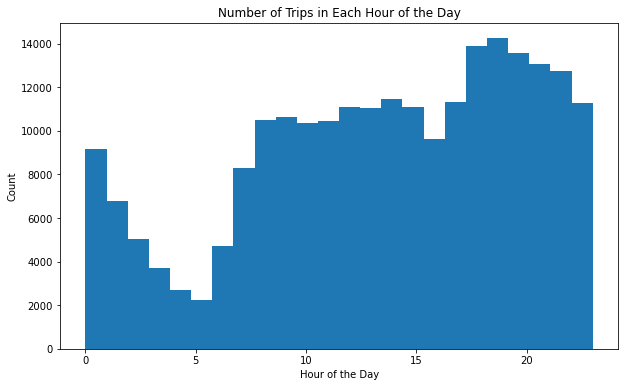

<Figure size 432x288 with 0 Axes>

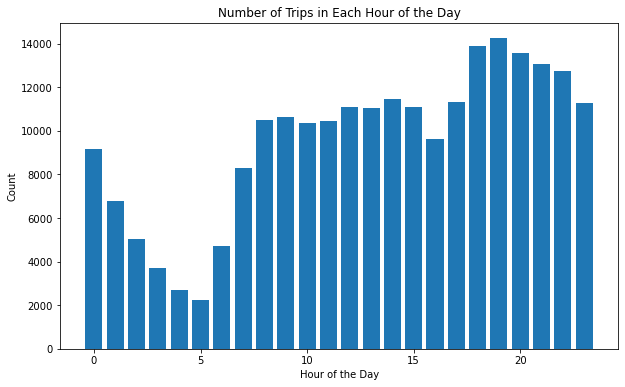

In [99]:
most_popular_hour()

#### 2. Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization.
We created a line plot to show the trend of how the average distance change in each month regardless of the year, given that "month" can be considered as numerical data. The accumulated average distances for 12 months throughout 7 years do not vary a lot, and all of them are above 3 miles on average. The average distance traveled reaches the peak in May. One of the reasons can be that the spring semester ends in many schools and students commnute to move or travel. The average distance traveled reaches the trough in January and keep being low till March. One of the reasons can be that people go out less during winter time, particularly in the Nothern area suffering cold winters. 

In [100]:
def avg_distance_month():
    #retrieve the month from datetime
    taxi_trips['pickup_datetime']= pd.to_datetime(taxi_trips['pickup_datetime'])
    taxi_trips_1 = taxi_trips.loc[:,['pickup_datetime','distance']]
    taxi_trips_1['month'] = taxi_trips_1['pickup_datetime'].dt.month
    taxi_trips_1
    uber_trips['pickup_datetime']= pd.to_datetime(uber_trips['pickup_datetime'])
    uber_trips_1 = uber_trips.loc[:,['pickup_datetime','distance']]
    uber_trips_1['month'] = uber_trips_1['pickup_datetime'].dt.month
    uber_trips_1
    
    #combine two df and groupby month & take mean
    comb = uber_trips_1.append(taxi_trips_1)
    ay = comb.groupby('month').mean()
    ay.reset_index(inplace=True)

    #plot
    x=ay['month']
    y=ay['distance']
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(x,y, '-')
    
    #define 90% confidence interval
    ci = 1.645 * np.std(y)/np.sqrt(len(ay))
    plt.fill_between(x, (y-ci), (y+ci), color='blue', alpha=0.1)
    plt.xlabel('Month')
    plt.ylabel('Distance (mile)')
    plt.xticks(np.arange(1,13), x)
    plt.title('Average Distance Traveled Per Month')
    


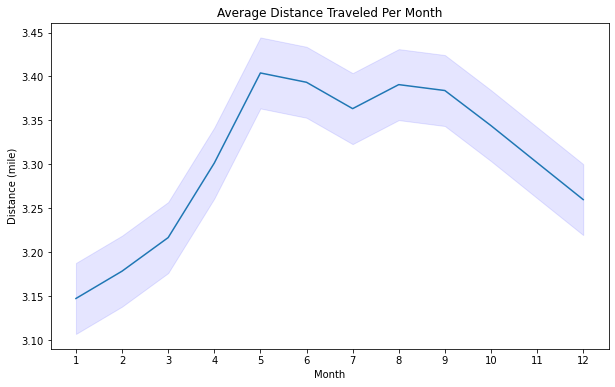

In [101]:
avg_distance_month()

#### 3. Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR. Create a visualization that compares what day of the week was most popular for drop offs for each airport.
We use line plot to visualize and compare the number of trips whose dropoff locations are in each of three airports. We convert day names (i.e. Monday) of a week into numbers (i.e. 1) to make it easier to compare and see the trends. As a result, for LGA, Friday is the most popular day. For JFK and EWR, it is Sunday. On each day of a week, the number of trips follows: LGA > JFK > EWR.

In [102]:
def popular_days_airport():
    
    LGA = [(40.767094, 286.110643-360), (40.783343, 286.144889-360)]
    JFK = [(40.621190, 286.176616-360), (40.664695, 286.253005-360)]
    EWR = [(40.671372, 285.808854-360), (40.708468, 285.847135-360)]


    uber_location = uber_trips.loc[:,['pickup_datetime','dropoff_latitude','dropoff_longitude']]
    dropoff_lag = uber_trips['dropoff_latitude']
    dropoff_log = uber_trips['dropoff_longitude']
    
    #for LGA
    uber_location_LGA = uber_location.loc[(dropoff_lag<=LGA[1][0]) & (dropoff_lag>=LGA[0][0]) & (dropoff_log<=LGA[1][1]) & (dropoff_log>=LGA[0][1])]
    uber_location_LGA['Day'] = pd.to_datetime(uber_location_LGA['pickup_datetime']).dt.day_name()
    LGA_week = uber_location_LGA.groupby('Day').count()
    LGA_week['day_number'] = [5,1,6,7,4,2,3]
    LGA_week = LGA_week.sort_values(by='day_number')

    x = LGA_week['day_number']
    y1= LGA_week['pickup_datetime']

    #for JFK
    uber_location_JFK = uber_location.loc[(dropoff_lag<=JFK[1][0]) & (dropoff_lag>=JFK[0][0]) & (dropoff_log<=JFK[1][1]) & (dropoff_log>=JFK[0][1])]
    uber_location_JFK['Day'] = pd.to_datetime(uber_location_JFK['pickup_datetime']).dt.day_name()
    JFK_week = uber_location_JFK.groupby('Day').count()
    JFK_week['day_number'] = [5,1,6,7,4,2,3]
    JFK_week = JFK_week.sort_values(by='day_number')

    y2= JFK_week['pickup_datetime']

    #for EWR
    uber_location_EWR = uber_location.loc[(dropoff_lag<=EWR[1][0]) & (dropoff_lag>=EWR[0][0]) & (dropoff_log<=EWR[1][1]) & (dropoff_log>=EWR[0][1])]

    uber_location_EWR['Day'] = pd.to_datetime(uber_location_EWR['pickup_datetime']).dt.day_name()
    EWR_week = uber_location_EWR.groupby('Day').count()
    EWR_week['day_number'] = [5,1,6,7,4,2,3]
    EWR_week = EWR_week.sort_values(by='day_number')
    
    y3= EWR_week['pickup_datetime']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(x,y1,label = "LGA")
    plt.plot(x,y2,label = "JFK")
    plt.plot(x,y3, label = "EWR")
    plt.xlabel('Day of a Week')
    plt.ylabel('Numer of Dropoff at the Airport')
    plt.title('Popularity of Weekdays at Each Airport')
    plt.legend()
    plt.show()
    

/var/folders/nl/z_0zj9p15vbblc0d3t46mtp40000gn/T/ipykernel_41156/4132527225.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_location_LGA['Day'] = pd.to_datetime(uber_location_LGA['pickup_datetime']).dt.day_name()
/var/folders/nl/z_0zj9p15vbblc0d3t46mtp40000gn/T/ipykernel_41156/4132527225.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_location_JFK['Day'] = pd.to_datetime(uber_location_JFK['pickup_datetime']).dt.day_name()
/var/folders/nl/z_0zj9p15vbblc0d3t46mtp40000gn/T/ipykernel_41156/4

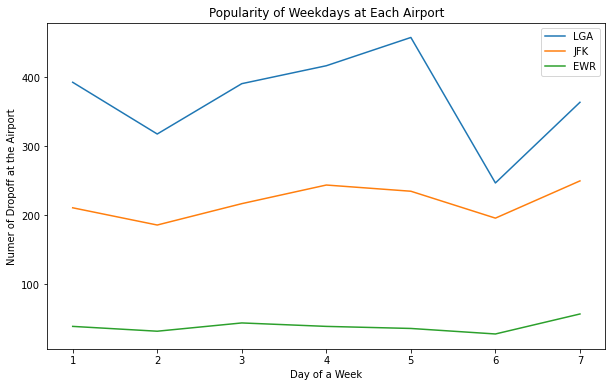

In [103]:
popular_days_airport()

#### 4. Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
The graph shows the pickup and dropoff points for both uber and yellow taxi trips. We add layers with different colors to differentiate. Yellow dots refer to the pickup locations of Uber trips, and red dots refer to the dropoff locations of them. Blue dots refers to the pickup locations of Yellow Taxi Trips, and purple dots refer to the dropoff locations. We differentiated the pickup and dropoff locations of Uber and yellow taxi using different colors and inserted a picture below, in case that the modification is not saved after re-running it.

In [104]:
def heatmap():
    heat_map=KeplerGl(height=500)
    heat_map.add_data(data=uber_trips,name='Uber Trips')
    heat_map.add_data(data=taxi_trips,name='Yellow Taxi Trips')
    return heat_map
    

In [105]:
heatmap()

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Uber Trips': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, â€¦

Visualization after manually adding layers (may not show after re-running the plot above):
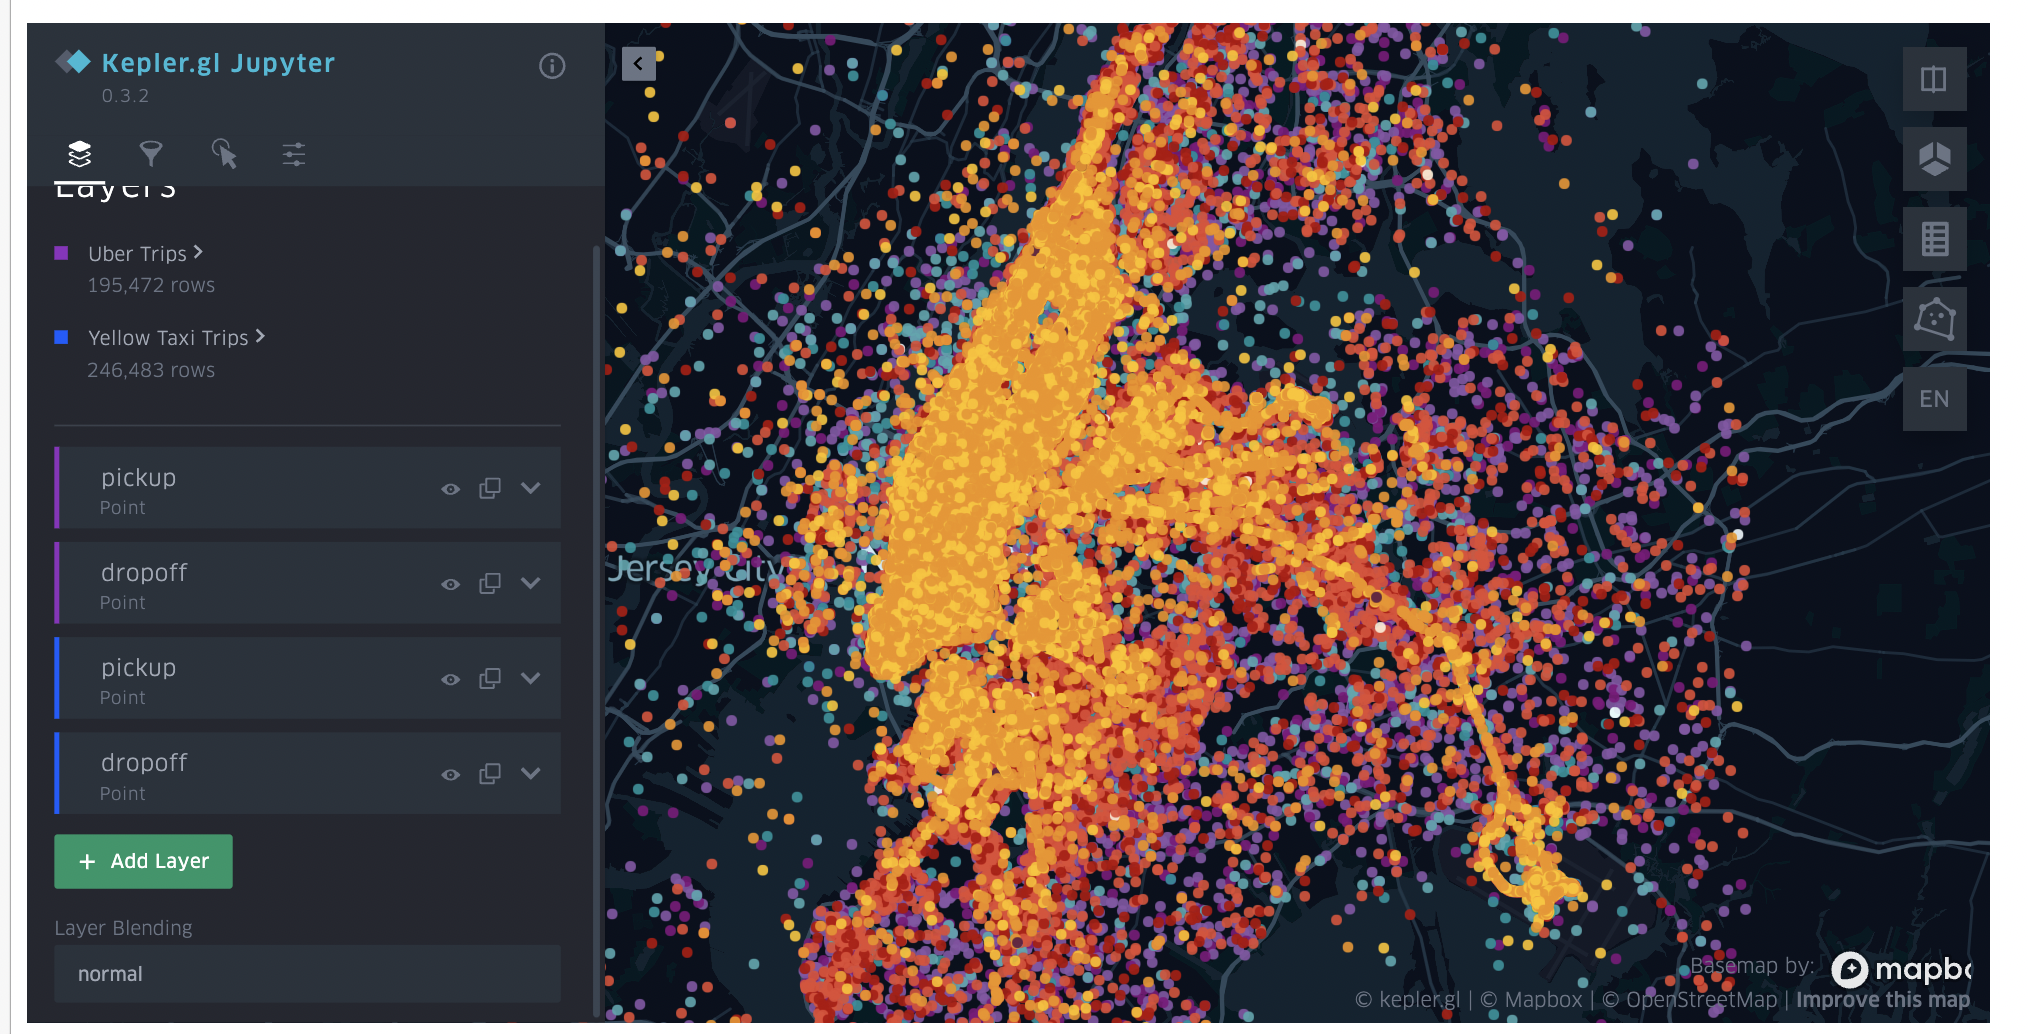

#### 5. Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. You may remove any outliers how you see fit.
By statistically determining outliers and removing them, we can see that most tip_amount are below 5 dollars. Many dots line up horizontally at the integer, indicating that most people tend to give rounded amount of tips. As distance increases, especially from 5 to 20 miles, the amount of tips tends to increase and more higher tip amounts ($3-4) are observed. As the distance increases, especially when reaching 30 miles, the number of zero tips decrease, and people tend to give higher amount of tips.

In [106]:
def corr_tip_distance():
    #trim df to two columns
    taxi_trips_1 = taxi_trips.loc[:,['tip_amount', 'distance']]
    #determine outliers
    dataset = taxi_trips_1['tip_amount']
    sorted(dataset)
    q1, q3= np.percentile(dataset,[25,75])
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr)
    #remove outliers 
    taxi_trips_2 = taxi_trips_1[taxi_trips_1['tip_amount']<=upper_bound]
    x=taxi_trips_2['distance']
    y=taxi_trips_2['tip_amount']
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.scatter(x, y, marker='o')
    plt.xlabel('Trip Distance (mile)')
    plt.ylabel('Tip Amount ($)')
    plt.title('Correlation between Tip Amount and Trip Distance for Yellow Taxi Rides (Without Outliers)')
    
    #plot the graph with some ourliers (till tip_amounts=$20) to compare
    taxi_trips_3 = taxi_trips_1[taxi_trips_1['tip_amount']<=20]
    a=taxi_trips_3['distance']
    b=taxi_trips_3['tip_amount']
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.scatter(a, b, marker='o')
    plt.xlabel('Trip Distance (mile)')
    plt.ylabel('Tip Amount ($)')
    plt.title('Correlation between Tip Amount and Trip Distance for Yellow Taxi Rides (With Outliers)')
    


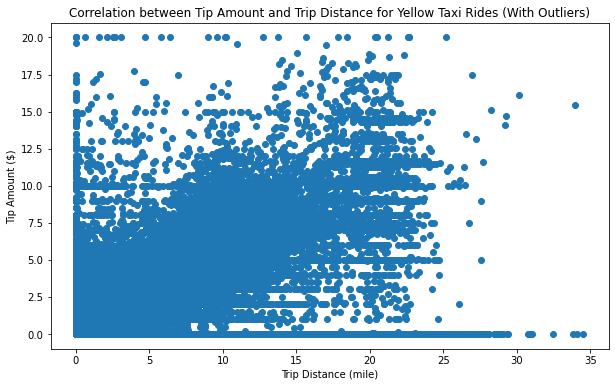

In [109]:
corr_tip_distance()

#### 6. Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit.
We retrive the date and hour information from Hourly Weather and Yellow Taxi Trips and group them by "Dates" and then "Hours". For weather data, we conduct grouby and then take sum to get the total amount of precipitation within that whole hour (if taking average, the result will not change based on the information the original data gives). 

For yellow taxi data, we conduct grouby and then take the average of all tips within that hour. The reason why we calculate mean is that we prefer to see the correlation between precipitation and tip amount on average, and how the precipitation may affect the amount of tips on the average level. The plot shows that when precipitation increases, some tips amount tend to increase, but there is not a super clear correlation shown.

In [110]:
def corr_tip_precip(taxi_trips,hourly_weather):
    #clean hourly_weather data & convert the data type into corrrect one
    hourly_weather['DATE'] = pd.Series(hourly_weather['DATE']).str.replace('T', ' ', regex=True)
    hourly_weather['Dates'] = pd.to_datetime(hourly_weather['DATE']).dt.date
    hourly_weather['Hours'] = pd.to_datetime(hourly_weather['DATE']).dt.hour
    hourly_weather_1 = hourly_weather[hourly_weather['HourlyPrecipitation'].notna()==True]
    hourly_weather_1 = hourly_weather_1[hourly_weather_1['HourlyPrecipitation']!='T']
    hourly_weather_1 = hourly_weather_1[hourly_weather_1["HourlyPrecipitation"].str.contains("s")==False]
    hourly_weather_1['HourlyPrecipitation'] = hourly_weather_1['HourlyPrecipitation'].apply(lambda x: float(x)) 
    hourly_weather_1 = hourly_weather_1.loc[:,['Dates','Hours','HourlyPrecipitation']]
    hourly_weather_1 = hourly_weather_1.groupby(['Dates','Hours']).sum()
    
    #clean taxi_trips data
    taxi_trips['pickup_datetime']= pd.to_datetime(taxi_trips['pickup_datetime'])
    taxi_trips['Dates'] = pd.to_datetime(taxi_trips['pickup_datetime']).dt.date
    taxi_trips['Hours'] = pd.to_datetime(taxi_trips['pickup_datetime']).dt.hour
    taxi_trips = taxi_trips.loc[:,['Dates','Hours','tip_amount']]
    
    #remove outliers
    dataset = taxi_trips['tip_amount']
    sorted(dataset)
    q1, q3= np.percentile(dataset,[25,75])
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr)
    taxi_trips_1 = taxi_trips[taxi_trips['tip_amount'] < upper_bound]
    
    #groupby & get mean values
    taxi_trips_grouped = taxi_trips_1.groupby(['Dates','Hours']).mean()
    
    #join two tables
    merged_tbl = taxi_trips_grouped.merge(hourly_weather_1, on=['Dates','Hours'], how='left')
    merged_tbl.reset_index(inplace=True)
    a=merged_tbl['HourlyPrecipitation']
    b=merged_tbl['tip_amount']
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.scatter(a, b, marker='o')
    plt.xlabel('Amount of Precipitation')
    plt.ylabel('Average Tips Amount within that Hour')
    plt.title('Correlation between Tips Amount and Precipitation for Yellow Taxi Rides')
    plt.show()
    
  

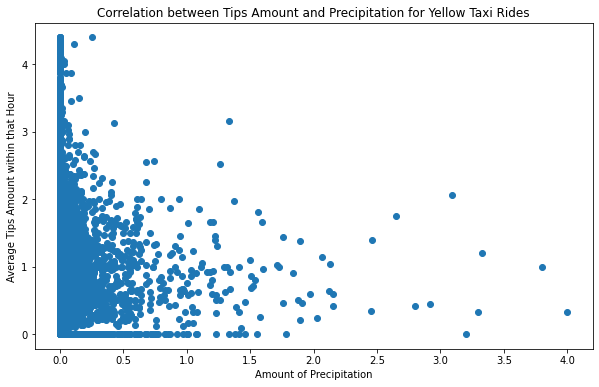

In [111]:
corr_tip_precip(taxi_trips,hourly_weather)

#### 7. Come up with 3 questions on your own that can be answered based on the data in the 4 tables. Create at least one visualization to answer each question. At least one visualization should require data from at least 3 tables.

##### 7-1. For 2009 through 2015, what day of the week that Uber drives most passenger?
We can see that in total, Uber drives most passengers on Saturday and least number of passengers on Monday.

In [112]:
def most_passenger_day():
    uber_trips['pickup_datetime']= pd.to_datetime(uber_trips['pickup_datetime'])
    uber_trips['day'] = uber_trips['pickup_datetime'].dt.day_name()

    uber_day = uber_trips.groupby('day').sum('passenger_count')
    uber_day['day_number'] = [5,1,6,7,4,2,3]
    uber_day=uber_day.sort_values(by='day_number')

    x = uber_day['day_number']
    y = uber_day['passenger_count']
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.bar(x,y);
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Passengers')
    plt.title('Number of Passenger of the Day in a Week')
    plt.subplots_adjust(left=0.2,
                    bottom=0.1, 
                    right=1.2, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.6)
    plt.show()

In [113]:
most_passenger_day()

### 7-2 Monthly fare of taxi distribution within 2015.
We choose the box plot to show the distribution and observe that in 2015, the fare amount does not vary a lot among different months. The mean fare amounts throughout different months are similar.

In [114]:
def fare_by_month():
    taxi_trips['Year']=pd.DatetimeIndex(taxi_trips['pickup_datetime']).year
    taxi_year=taxi_trips[['pickup_datetime','Year','fare_amount','distance']]
    taxi_year=taxi_year[taxi_trips['Year']==2015]
    taxi_year['Month']=pd.DatetimeIndex(taxi_year['pickup_datetime']).month

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x=taxi_year['Month'],y=taxi_year['fare_amount'],data=taxi_year,ax=ax)
    
    plt.xlabel('Month')
    plt.ylabel('Amount of Fare')
    plt.title('Distribution of Fare Amount by Months in 2015')


In [115]:
fare_by_month()

##### 7-3. Visualize the correlation between wind speed and number of trips for Uber and yellow taxies.
We use scatterplot to explore the possible coorelation between daily average wind speed and the daily total number of trips. It does not show a clear correlation. Yellow taxies shows larger number of trips than Uber throughout the years.

In [116]:
def windspeed_trips_number():
    windspeed = daily_weather.sort_values(by='DailyAverageWindSpeed',ascending=False).loc[:,['DATE','DailyAverageWindSpeed']]
    windspeed['DATE'] = pd.Series(windspeed['DATE']).str.replace('T', ' ', regex=True)
    windspeed['pickup_datetime'] = pd.to_datetime(windspeed['DATE']).dt.date

    windspeed = windspeed[windspeed['DailyAverageWindSpeed'].notna()==True]
    taxi_trips['pickup_datetime']= pd.to_datetime(taxi_trips['pickup_datetime']).dt.date
    taxi_trips_dist = taxi_trips.groupby('pickup_datetime').count()
    

    uber_trips['pickup_datetime']= pd.to_datetime(uber_trips['pickup_datetime']).dt.date
    uber_trips_dist = uber_trips.groupby('pickup_datetime').count()

    
    taxi_trips_dist.reset_index(inplace=True)    
    uber_trips_dist.reset_index(inplace=True)
    
    comb_1 = windspeed.merge(taxi_trips_dist, how='left',on='pickup_datetime')
    comb_1 = comb_1[['DailyAverageWindSpeed','id']]

    comb_2 = windspeed.merge(uber_trips_dist, how='left',on='pickup_datetime')
    comb_2 = comb_2[['DailyAverageWindSpeed','id']]

    x=comb_1['DailyAverageWindSpeed']
    y1=comb_1['id']
    y2=comb_2['id']
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.scatter(x,y1,label = "Yellow Taxi")
    plt.scatter(x,y2,label = "Uber")
    plt.xlabel('Daily Average Wind Speed')
    plt.ylabel('Number of Trips')
    plt.title('Correlation between Wind Speed and Trips for Uber and Yellow Taxi')
    plt.xlim(0,17.5)
    plt.ylim(15,160)
    plt.subplots_adjust(left=0.2,
                    bottom=0.1, 
                    right=1.2, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.6)

    plt.legend()
    plt.show()

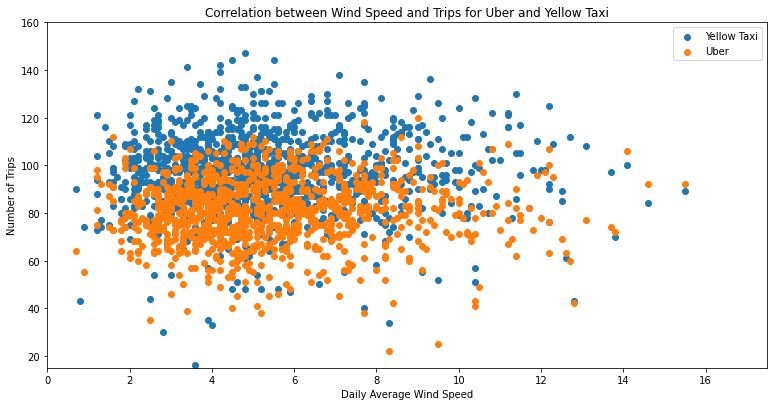

In [117]:
windspeed_trips_number()